In [1]:
#@title Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import warnings
warnings.filterwarnings("ignore")

In [2]:
#@title Importando datasets

from google.colab import drive
drive.mount('/content/drive')

train  = pd.read_csv('/content/drive/MyDrive/Kaggle/Store Sales - Time Series Forecasting/train.csv')
test   = pd.read_csv('/content/drive/MyDrive/Kaggle/Store Sales - Time Series Forecasting/test.csv')
stores = pd.read_csv('/content/drive/MyDrive/Kaggle/Store Sales - Time Series Forecasting/stores.csv')
oil    = pd.read_csv('/content/drive/MyDrive/Kaggle/Store Sales - Time Series Forecasting/oil.csv')
holiday_events = pd.read_csv('/content/drive/MyDrive/Kaggle/Store Sales - Time Series Forecasting/holidays_events.csv')
transactions = pd.read_csv('/content/drive/MyDrive/Kaggle/Store Sales - Time Series Forecasting/transactions.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/Kaggle/Store Sales - Time Series Forecasting/sample_submission.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Pasar todo a Datetime
train["date"] = pd.to_datetime(train["date"])
test["date"] = pd.to_datetime(test["date"])
holiday_events["date"] = pd.to_datetime(holiday_events["date"])
oil["date"] = pd.to_datetime(oil["date"])
transactions["date"] = pd.to_datetime(transactions["date"])

# Feature Engineering

In [4]:
#@title Preparando holiday_events para merge
hol_nat = holiday_events[
    (holiday_events["locale"] == "National") &
    (holiday_events["transferred"] == False)
]

hol_nat = hol_nat[["date"]].drop_duplicates()
hol_nat["is_holiday"] = 1

calendar = pd.DataFrame({
    "date": pd.date_range(train["date"].min(), test["date"].max(), freq="D")
})

hol_cal = calendar.merge(hol_nat, on="date", how="left")
hol_cal["is_holiday"] = hol_cal["is_holiday"].fillna(0).astype(int)

# >>> hol_cal ahora tiene todas las fechas con 0/1 de feriado

In [5]:
#@title Preparando oil para merge
oil["dcoilwtico"] = pd.to_numeric(oil["dcoilwtico"], errors="coerce")

oil = oil.sort_values("date").copy()
oil["dcoilwtico"] = oil["dcoilwtico"].ffill().bfill()

cal = pd.DataFrame({"date": pd.date_range(train["date"].min(), test["date"].max(), freq="D")})
oil_cal = cal.merge(oil, on="date", how="left")
oil_cal["dcoilwtico"] = oil_cal["dcoilwtico"].ffill().bfill()

#Medias móviles útiles
oil_cal["MA_50"]  = oil_cal["dcoilwtico"].rolling(50, min_periods=1).mean()
oil_cal["MA_200"] = oil_cal["dcoilwtico"].rolling(200, min_periods=1).mean()

In [6]:
train = train.merge(hol_cal, on="date", how="left")
test  = test.merge(hol_cal,  on="date", how="left")
train = train.merge(oil_cal, on="date", how="left")
test  = test.merge(oil_cal,  on="date", how="left")

In [7]:
train = train.merge(transactions, on=["date", "store_nbr"], how="left")
test  = test.merge(transactions, on=["date", "store_nbr"], how="left")


train["transactions"] = train["transactions"].fillna(0).astype(int)
test["transactions"]  = test["transactions"].fillna(0).astype(int)

#EDA

In [8]:
train.isna().sum()

,0
id,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0
is_holiday,0
dcoilwtico,0
MA_50,0
MA_200,0


In [16]:
pd.options.display.float_format = '{:.2f}'.format
train.describe()

,id,date,store_nbr,sales,onpromotion,is_holiday,dcoilwtico,MA_50,MA_200,transactions,month,xgboost_predictions
count,3000888.00,3000888,3000888.00,3000888.00,3000888.00,3000888.00,3000888.00,3000888.00,3000888.00,3000888.00,3000888.00,3000888.00
mean,1500443.50,2015-04-24 08:27:04.703088384,27.50,357.78,2.60,0.08,67.92,68.59,70.64,1555.81,6.21,357.78
min,0.00,2013-01-01 00:00:00,1.00,0.00,0.00,0.00,26.19,30.54,37.43,0.00,1.00,-779.81
25%,750221.75,2014-02-26 18:00:00,14.00,0.00,0.00,0.00,46.38,46.92,48.09,930.00,3.00,4.25
50%,1500443.50,2015-04-24 12:00:00,27.50,11.00,0.00,0.00,53.41,53.18,59.11,1331.00,6.00,20.28
75%,2250665.25,2016-06-19 06:00:00,41.00,195.85,0.00,0.00,95.72,95.44,97.87,1976.25,9.00,200.95
max,3000887.00,2017-08-15 00:00:00,54.00,124717.00,741.00,1.00,110.62,107.27,102.13,8359.00,12.00,101023.38
std,866281.89,NaN,15.59,1102.00,12.22,0.27,25.67,25.57,24.92,1033.37,3.39,1066.04


In [10]:
train.nunique()

,0
id,3000888
date,1684
store_nbr,54
family,33
sales,379610
onpromotion,362
is_holiday,2
dcoilwtico,994
MA_50,1673
MA_200,1680


In [11]:
train.dtypes

,0
id,int64
date,datetime64[ns]
store_nbr,int64
family,object
sales,float64
onpromotion,int64
is_holiday,int64
dcoilwtico,float64
MA_50,float64
MA_200,float64


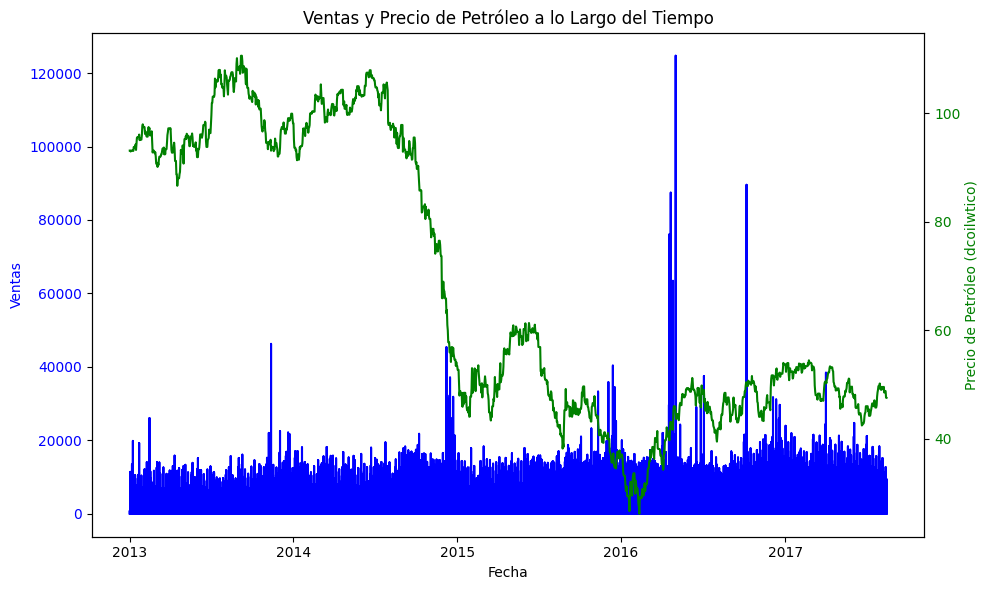

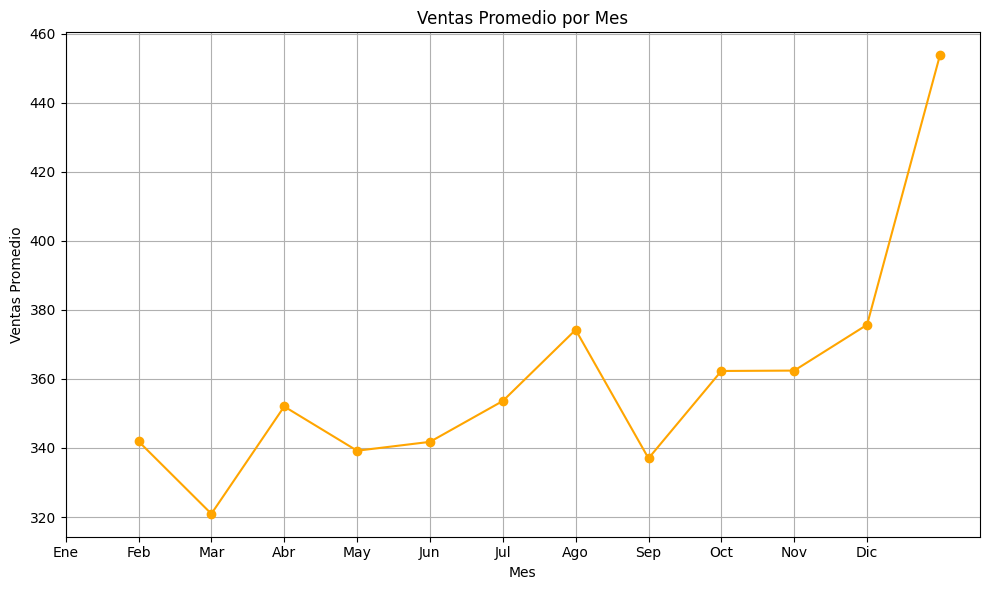

In [12]:

train = train.sort_values("date")

# Graficar las ventas y el valor de petróleo (con dos ejes y)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Eje 1: Ventas
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Ventas', color='blue')
ax1.plot(train["date"], train["sales"], color='blue', label="Ventas")
ax1.tick_params(axis='y', labelcolor='blue')

# Eje 2: Precio de petróleo
ax2 = ax1.twinx()  # Crear el segundo eje
ax2.set_ylabel('Precio de Petróleo (dcoilwtico)', color='green')
ax2.plot(train["date"], train["dcoilwtico"], color='green', label="Precio de Petróleo")
ax2.tick_params(axis='y', labelcolor='green')

# Títulos y leyendas
plt.title("Ventas y Precio de Petróleo a lo Largo del Tiempo")
fig.tight_layout()

# Rotar las fechas para mejor visibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()


# Mostrar el gráfico
plt.show()

train["month"] = train["date"].dt.month
monthly_sales = train.groupby("month")["sales"].mean()

plt.figure(figsize=(10, 6))
plt.plot(monthly_sales, marker='o', color='orange')
plt.title("Ventas Promedio por Mes")
plt.xlabel("Mes")
plt.ylabel("Ventas Promedio")
plt.grid(True)
plt.xticks(range(12), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.tight_layout()
plt.show()

# XGBoost

In [43]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor # Importar LGBM también aquí si se va a usar en celdas posteriores
from sklearn.model_selection import train_test_split

# Apply one-hot encoding to the 'family' column
X = pd.get_dummies(train.drop(['sales', 'date'], axis=1), columns=['family'])
y = train['sales']

X.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X.columns]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

xgboost_model = XGBRegressor(n_estimators=200,
                             max_depth=7,
                             learning_rate=0.05,
                             random_state=42)
xgboost_model.fit(X_train, y_train)

train['xgboost_predictions'] = xgboost_model.predict(X)
train.tail()

,id,date,store_nbr,family,sales,onpromotion,is_holiday,dcoilwtico,MA_50,MA_200,transactions,month,xgboost_predictions,lgbm_predictions
2999693,2999693,2017-08-15,25,PET SUPPLIES,3.00,0,0,47.57,47.14,49.05,849,8,4.63,11.04
2999692,2999692,2017-08-15,25,PERSONAL CARE,93.00,8,0,47.57,47.14,49.05,849,8,156.83,164.26
2999691,2999691,2017-08-15,25,MEATS,180.11,0,0,47.57,47.14,49.05,849,8,171.96,174.80
2999702,2999702,2017-08-15,26,BEAUTY,0.00,0,0,47.57,47.14,49.05,534,8,3.86,11.04
3000887,3000887,2017-08-15,9,SEAFOOD,16.00,0,0,47.57,47.14,49.05,2155,8,19.28,24.71


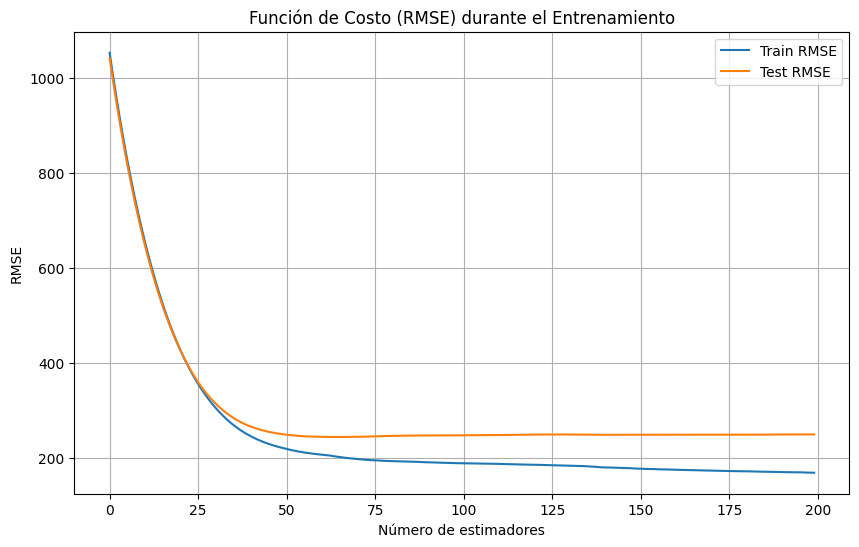

In [44]:

eval_set = [(X_train, y_train), (X_test, y_test)]
xgboost_model.fit(X_train, y_train, eval_set=eval_set, verbose=False) # verbose=False para no imprimir cada iteración

# Obtener los resultados de la evaluación
results = xgboost_model.evals_result()


epochs = len(results['validation_0']['rmse'])
x = range(epochs)

plt.figure(figsize=(10, 6))
plt.plot(x, results['validation_0']['rmse'], label='Train RMSE')
plt.plot(x, results['validation_1']['rmse'], label='Test RMSE')
plt.xlabel('Número de estimadores')
plt.ylabel('RMSE')
plt.title('Función de Costo (RMSE) durante el Entrenamiento')
plt.legend()
plt.grid(True)
plt.show()


=== Reporte de métricas para modelo: xgboost_model ===



,Métrica,Train,Test
0,RMSE,168.71,249.34
1,MAE,44.84,48.33
2,MAPE (%),52.17,52.40
3,R²,0.98,0.95
4,R² ajustado,0.98,0.95
5,Explained Variance,0.98,0.95
6,Median AE,5.02,5.05
7,Max Error,47759.63,121210.73
8,NWRMSLE,0.71,0.71


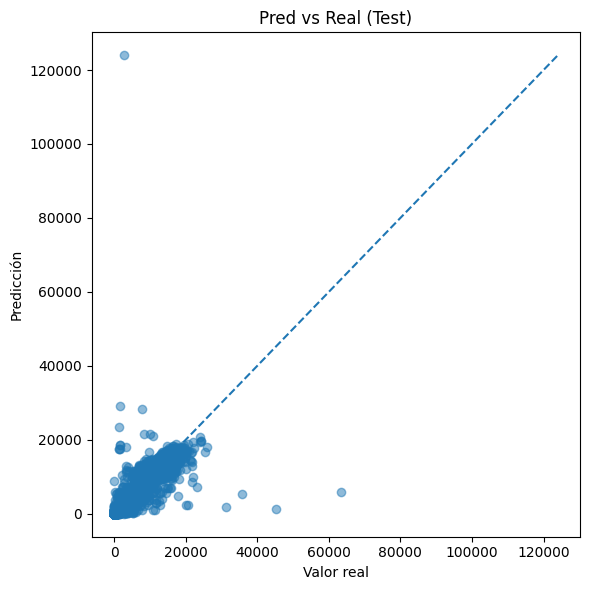

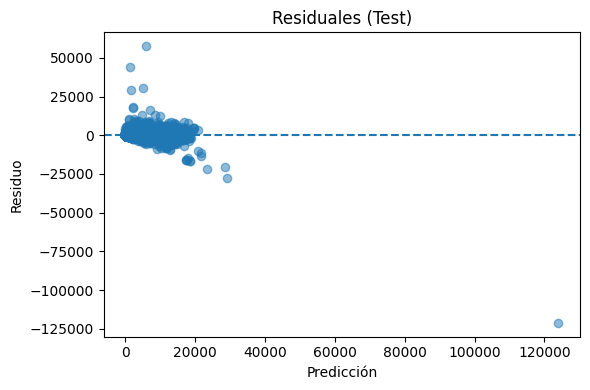

,Métrica,Train,Test
0,RMSE,168.71,249.34
1,MAE,44.84,48.33
2,MAPE (%),52.17,52.40
3,R²,0.98,0.95
4,R² ajustado,0.98,0.95
5,Explained Variance,0.98,0.95
6,Median AE,5.02,5.05
7,Max Error,47759.63,121210.73
8,NWRMSLE,0.71,0.71


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score,
    median_absolute_error,
    max_error
)

# --- MAPE robusto (evita división por ~0) ---
def _safe_mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    mask = np.abs(y_true) > eps
    if not np.any(mask):
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0

# --- NWRMSLE (no existe en sklearn; se define a mano) ---
def nwrmsle(y_true, y_pred, weights=None):
    """
    Normalized Weighted Root Mean Squared Logarithmic Error
    NWRMSLE = sqrt( sum_i w_i * (log1p(yhat_i) - log1p(y_i))^2 / sum_i w_i )
    """
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()

    # pesos
    if weights is None:
        weights = np.ones_like(y_true, dtype=float)
    else:
        weights = np.asarray(weights, dtype=float).ravel()
        if weights.shape[0] != y_true.shape[0]:
            raise ValueError("El vector de pesos debe tener la misma longitud que y_true.")

    # forzar no-negativos
    y_true = np.maximum(0, y_true)
    y_pred = np.maximum(0, y_pred)

    log_diff = np.log1p(y_pred) - np.log1p(y_true)
    return np.sqrt(np.sum(weights * (log_diff ** 2)) / np.sum(weights))

# --- Reporte ---
def regression_report_for_xgb(
    X_train, y_train, X_test, y_test,
    model_name_var="xgboost_model",
    weights_train=None, weights_test=None,
    show_plots=True
):
    mdl = globals().get(model_name_var, None)
    if mdl is None:
        raise NameError(f"No encontré '{model_name_var}' en memoria.")

    # Predicciones
    y_train_pred = mdl.predict(X_train)
    y_test_pred  = mdl.predict(X_test)

    # Métricas (RMSE = sqrt(MSE))
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test  = np.sqrt(mean_squared_error(y_test,  y_test_pred))
    mae_train  = mean_absolute_error(y_train, y_train_pred)
    mae_test   = mean_absolute_error(y_test,  y_test_pred)
    mape_train = _safe_mape(y_train, y_train_pred)
    mape_test  = _safe_mape(y_test,  y_test_pred)
    r2_train   = r2_score(y_train, y_train_pred)
    r2_test    = r2_score(y_test,  y_test_pred)
    evs_train  = explained_variance_score(y_train, y_train_pred)
    evs_test   = explained_variance_score(y_test,  y_test_pred)
    medae_train = median_absolute_error(y_train, y_train_pred)
    medae_test  = median_absolute_error(y_test,  y_test_pred)
    maxerr_train = max_error(y_train, y_train_pred)
    maxerr_test  = max_error(y_test,  y_test_pred)

    # NWRMSLE (opcionalmente con pesos)
    nwrmsle_train = nwrmsle(y_train, y_train_pred, weights_train)
    nwrmsle_test  = nwrmsle(y_test,  y_test_pred,  weights_test)

    # R² ajustado
    def adj_r2(r2, n, p):
        return 1 - (1 - r2) * (n - 1) / (n - p - 1) if n > p + 1 else np.nan
    adj_r2_train = adj_r2(r2_train, len(y_train), X_train.shape[1])
    adj_r2_test  = adj_r2(r2_test,  len(y_test),  X_test.shape[1])

    # Tabla
    metrics = pd.DataFrame({
        "Métrica": [
            "RMSE", "MAE", "MAPE (%)", "R²", "R² ajustado",
            "Explained Variance", "Median AE", "Max Error", "NWRMSLE"
        ],
        "Train": [
            rmse_train, mae_train, mape_train, r2_train, adj_r2_train,
            evs_train, medae_train, maxerr_train, nwrmsle_train
        ],
        "Test": [
            rmse_test, mae_test, mape_test, r2_test, adj_r2_test,
            evs_test, medae_test, maxerr_test, nwrmsle_test
        ]
    })

    print("\n=== Reporte de métricas para modelo:", model_name_var, "===\n")
    try:
        display(metrics)  # Jupyter/Colab
    except:
        print(metrics.to_string(index=False))

    if show_plots:
        # Pred vs Real (Test)
        plt.figure(figsize=(6, 6))
        plt.scatter(y_test, y_test_pred, alpha=0.5)
        lims = [min(np.min(y_test), np.min(y_test_pred)), max(np.max(y_test), np.max(y_test_pred))]
        plt.plot(lims, lims, linestyle="--")
        plt.xlabel("Valor real")
        plt.ylabel("Predicción")
        plt.title("Pred vs Real (Test)")
        plt.tight_layout()
        plt.show()

        # Residuales (Test)
        resid = np.asarray(y_test) - np.asarray(y_test_pred)
        plt.figure(figsize=(6, 4))
        plt.scatter(y_test_pred, resid, alpha=0.5)
        plt.axhline(0, linestyle="--")
        plt.xlabel("Predicción")
        plt.ylabel("Residuo")
        plt.title("Residuales (Test)")
        plt.tight_layout()
        plt.show()

    return metrics

# === Uso básico (sin pesos) ===
regression_report_for_xgb(X_train, y_train, X_test, y_test,
                          model_name_var="xgboost_model", show_plots=True)

# === Uso con pesos (ej. Favorita: 1 + 0.25*perishable) ===
# weights = 1.0 + 0.25 * train['perishable']
# regression_report_for_xgb(
#     X_train, y_train, X_test, y_test,
#     model_name_var="xgboost_model",
#     weights_train=weights.iloc[y_train.index],
#     weights_test=weights.iloc[y_test.index],
#     show_plots=True
# )


In [35]:
#@title Realizamos GridSearch para mejorar hiperparametros
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor


subset_size = 200000
X_train_subset = X_train.sample(n=subset_size, random_state=42)
y_train_subset = y_train.loc[X_train_subset.index] # Asegurarse de que los índices coincidan

# Definir una grilla de parámetros más amplia para una búsqueda más robusta
param_grid = {
    'n_estimators': [100, 200, 300, 400], # Mayor rango de estimadores
    'max_depth': [5, 7, 10, 12],       # Explorar más profundidades de árbol
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3] # Explorar más tasas de aprendizaje
}

# Inicializar el modelo XGBoostRegressor
xgb = XGBRegressor(random_state=42)


grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           scoring='neg_root_mean_squared_error', # Usar RMSE como métrica, negado para maximizar
                           cv=3, n_jobs=-1, verbose=2)

# Ejecutar el GridSearch en el subconjunto
print("Iniciando GridSearch en un subconjunto de datos...")
grid_search.fit(X_train_subset, y_train_subset)

# Mostrar los mejores parámetros y el mejor score
print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)
print("\nMejor score (neg_root_mean_squared_error) encontrado:")
print(grid_search.best_score_)

# El mejor modelo entrenado en el subconjunto
best_xgboost_model = grid_search.best_estimator_



Iniciando GridSearch en un subconjunto de datos...
Fitting 3 folds for each of 80 candidates, totalling 240 fits

Mejores parámetros encontrados:
{'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100}

Mejor score (neg_root_mean_squared_error) encontrado:
-182.8598290403877


# LightGBM

In [50]:
from lightgbm import LGBMRegressor
from lightgbm.callback import early_stopping # Importar early_stopping

# Inicializar y entrenar el modelo LightGBM
lgbm_model = LGBMRegressor(random_state=42,
                           learning_rate=0.1,
                           max_depth=5,
                           n_estimators=400,
                           num_leaves=64)

print("Entrenando modelo LightGBM...")
lgbm_model.fit(X_train, y_train,
               eval_set=[(X_test, y_test)],
               eval_metric='rmse', # Opcional: especificar métrica de evaluación
               callbacks=[early_stopping(10, verbose=False)]) # Usar early_stopping directamente

print("Entrenamiento de LightGBM completado.")


train['lgbm_predictions'] = lgbm_model.predict(X)

# Asegurarse de que las predicciones no sean negativas
train['lgbm_predictions'][train['lgbm_predictions'] < 0] = 0

# Mostrar las últimas filas del dataframe de entrenamiento con las predicciones de LGBM
display(train.tail())

Entrenando modelo LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2120
[LightGBM] [Info] Number of data points in the train set: 2100621, number of used features: 44
[LightGBM] [Info] Start training from score 358.818248
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

,id,date,store_nbr,family,sales,onpromotion,is_holiday,dcoilwtico,MA_50,MA_200,transactions,month,xgboost_predictions,lgbm_predictions
2999693,2999693,2017-08-15,25,PET SUPPLIES,3.00,0,0,47.57,47.14,49.05,849,8,4.63,7.28
2999692,2999692,2017-08-15,25,PERSONAL CARE,93.00,8,0,47.57,47.14,49.05,849,8,156.83,156.54
2999691,2999691,2017-08-15,25,MEATS,180.11,0,0,47.57,47.14,49.05,849,8,171.96,170.47
2999702,2999702,2017-08-15,26,BEAUTY,0.00,0,0,47.57,47.14,49.05,534,8,3.86,6.61
3000887,3000887,2017-08-15,9,SEAFOOD,16.00,0,0,47.57,47.14,49.05,2155,8,19.28,22.79



=== Reporte de métricas para modelo: lgbm_model ===



,Métrica,Train,Test
0,RMSE,191.77,220.16
1,MAE,46.04,49.00
2,MAPE (%),74.02,74.17
3,R²,0.97,0.96
4,R² ajustado,0.97,0.96
5,Explained Variance,0.97,0.96
6,Median AE,6.19,6.22
7,Max Error,91770.17,56379.86
8,NWRMSLE,1.05,1.05


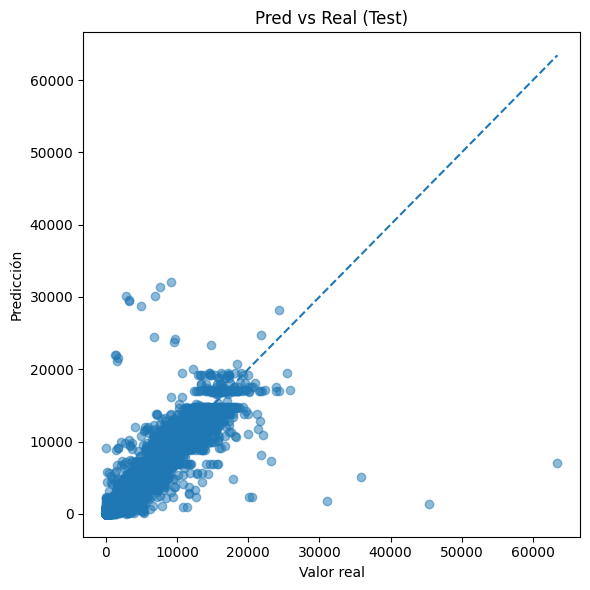

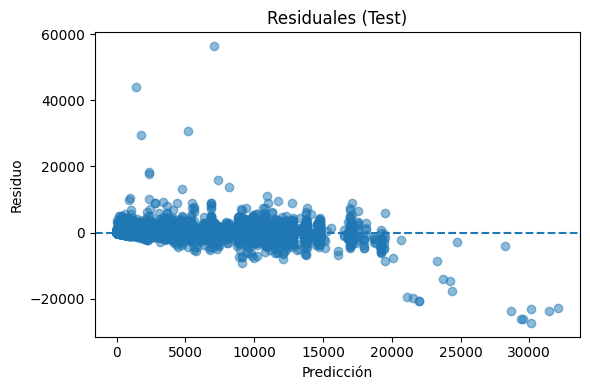

,Métrica,Train,Test
0,RMSE,191.77,220.16
1,MAE,46.04,49.00
2,MAPE (%),74.02,74.17
3,R²,0.97,0.96
4,R² ajustado,0.97,0.96
5,Explained Variance,0.97,0.96
6,Median AE,6.19,6.22
7,Max Error,91770.17,56379.86
8,NWRMSLE,1.05,1.05


In [51]:
# Generar el reporte de métricas para el modelo LightGBM
regression_report_for_xgb(X_train, y_train, X_test, y_test,
                          model_name_var="lgbm_model", show_plots=True)

In [49]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor


subset_size = 200000
X_train_subset = X_train.sample(n=subset_size, random_state=42)
y_train_subset = y_train.loc[X_train_subset.index]


# Definir una grilla de parámetros más amplia para LightGBM
param_grid_lgbm = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 7, 10, 12],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'num_leaves': [31, 64, 128]
}


# Inicializar el modelo LGBMRegressor
lgbm = LGBMRegressor(random_state=42)

# Configurar GridSearchCV
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid_lgbm,
                           scoring='neg_root_mean_squared_error', # Usar RMSE como métrica, negado para maximizar
                           cv=3, n_jobs=-1, verbose=2)

# Ejecutar el GridSearch en el subconjunto
print("Iniciando GridSearch en un subconjunto de datos para LightGBM...")
grid_search_lgbm.fit(X_train_subset, y_train_subset)


# Mostrar los mejores parámetros y el mejor score
print("\nMejores parámetros encontrados para LightGBM:")
print(grid_search_lgbm.best_params_)
print("\nMejor score (neg_root_mean_squared_error) encontrado para LightGBM:")
print(grid_search_lgbm.best_score_)

# El mejor modelo entrenado en el subconjunto
best_lgbm_model = grid_search_lgbm.best_estimator_

Iniciando GridSearch en un subconjunto de datos para LightGBM...
Fitting 3 folds for each of 240 candidates, totalling 720 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2121
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 44
[LightGBM] [Info] Start training from score 360.553357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

# Catboost

In [53]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 12.6 MB/s eta 0:00:00


In [54]:
from catboost import CatBoostRegressor

catboost_model = CatBoostRegressor(random_state=42,
                                   verbose=0)

print("Entrenando modelo CatBoost...")
catboost_model.fit(X_train, y_train,
                   eval_set=(X_test, y_test),
                   early_stopping_rounds=10) # Opcional: early stopping

print("Entrenamiento de CatBoost completado.")

# Hacer predicciones en el conjunto de entrenamiento
train['catboost_predictions'] = catboost_model.predict(X)

# Asegurarse de que las predicciones no sean negativas
train['catboost_predictions'][train['catboost_predictions'] < 0] = 0

# Mostrar las últimas filas del dataframe de entrenamiento con las predicciones de CatBoost
display(train.tail())

Entrenando modelo CatBoost...
Entrenamiento de CatBoost completado.


,id,date,store_nbr,family,sales,onpromotion,is_holiday,dcoilwtico,MA_50,MA_200,transactions,month,xgboost_predictions,lgbm_predictions,catboost_predictions
2999693,2999693,2017-08-15,25,PET SUPPLIES,3.00,0,0,47.57,47.14,49.05,849,8,4.63,7.28,19.12
2999692,2999692,2017-08-15,25,PERSONAL CARE,93.00,8,0,47.57,47.14,49.05,849,8,156.83,156.54,156.68
2999691,2999691,2017-08-15,25,MEATS,180.11,0,0,47.57,47.14,49.05,849,8,171.96,170.47,186.44
2999702,2999702,2017-08-15,26,BEAUTY,0.00,0,0,47.57,47.14,49.05,534,8,3.86,6.61,19.12
3000887,3000887,2017-08-15,9,SEAFOOD,16.00,0,0,47.57,47.14,49.05,2155,8,19.28,22.79,27.07



=== Reporte de métricas para modelo: catboost_model ===



,Métrica,Train,Test
0,RMSE,208.44,218.13
1,MAE,54.42,56.90
2,MAPE (%),213.79,213.48
3,R²,0.96,0.96
4,R² ajustado,0.96,0.96
5,Explained Variance,0.96,0.96
6,Median AE,18.96,18.96
7,Max Error,97433.46,57807.35
8,NWRMSLE,1.85,1.85


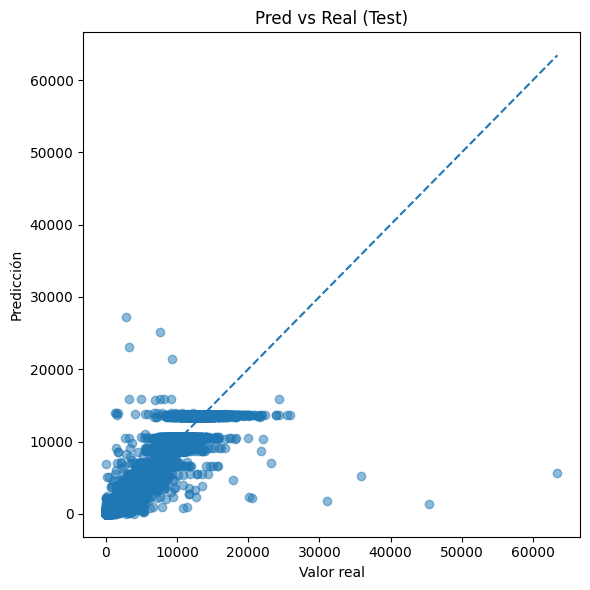

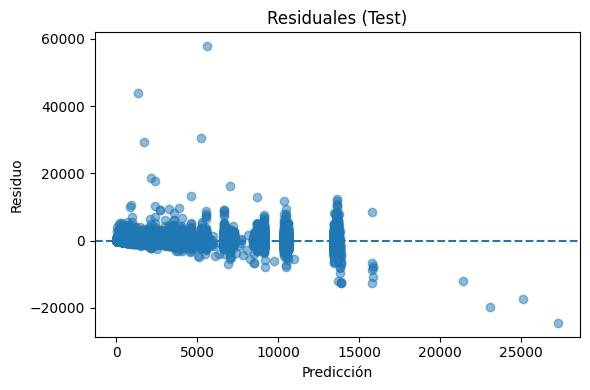

,Métrica,Train,Test
0,RMSE,208.44,218.13
1,MAE,54.42,56.90
2,MAPE (%),213.79,213.48
3,R²,0.96,0.96
4,R² ajustado,0.96,0.96
5,Explained Variance,0.96,0.96
6,Median AE,18.96,18.96
7,Max Error,97433.46,57807.35
8,NWRMSLE,1.85,1.85


In [55]:
regression_report_for_xgb(X_train, y_train, X_test, y_test,
                          model_name_var="catboost_model", show_plots=True)

# Elección del modelo

In [57]:
# Obtener los reportes de métricas para cada modelo
# Asegurarse de que los modelos (xgboost_model, lgbm_model, catboost_model) estén entrenados
print("Generando reporte para XGBoost...")
metrics_xgb = regression_report_for_xgb(X_train, y_train, X_test, y_test,
                                        model_name_var="xgboost_model", show_plots=False)

print("\nGenerando reporte para LightGBM...")
metrics_lgbm = regression_report_for_xgb(X_train, y_train, X_test, y_test,
                                         model_name_var="lgbm_model", show_plots=False)

print("\nGenerando reporte para CatBoost...")
metrics_catboost = regression_report_for_xgb(X_train, y_train, X_test, y_test,
                                           model_name_var="catboost_model", show_plots=False)


# Renombrar las columnas de los reportes para la comparación
metrics_xgb = metrics_xgb.rename(columns={"Train": "XGBoost Train", "Test": "XGBoost Test"})
metrics_lgbm = metrics_lgbm.rename(columns={"Train": "LightGBM Train", "Test": "LightGBM Test"})
metrics_catboost = metrics_catboost.rename(columns={"Train": "CatBoost Train", "Test": "CatBoost Test"})


# Combinar los reportes en una sola tabla
comparison_table = metrics_xgb.merge(metrics_lgbm, on="Métrica").merge(metrics_catboost, on="Métrica")

# Mostrar la tabla comparativa
print("\n=== Tabla Comparativa de Métricas ===")
display(comparison_table)

# --- Selección del mejor modelo basado en NWRMSLE (en el conjunto de Test) ---
print("\n=== Selección del Mejor Modelo (basado en NWRMSLE en Test) ===")

# Extraer la fila de NWRMSLE
nwrmsle_row = comparison_table[comparison_table["Métrica"] == "NWRMSLE"]

# Obtener los valores de NWRMSLE en el conjunto de Test
nwrmsle_test_xgb = nwrmsle_row["XGBoost Test"].iloc[0]
nwrmsle_test_lgbm = nwrmsle_row["LightGBM Test"].iloc[0]
nwrmsle_test_catboost = nwrmsle_row["CatBoost Test"].iloc[0]

# Determinar el mejor modelo (el que tiene el menor NWRMSLE en Test)
best_model_name = ""
min_nwrmsle_test = float('inf')

if nwrmsle_test_xgb < min_nwrmsle_test:
    min_nwrmsle_test = nwrmsle_test_xgb
    best_model_name = "XGBoost"

if nwrmsle_test_lgbm < min_nwrmsle_test:
    min_nwrmsle_test = nwrmsle_test_lgbm
    best_model_name = "LightGBM"

if nwrmsle_test_catboost < min_nwrmsle_test:
    min_nwrmsle_test = nwrmsle_test_catboost
    best_model_name = "CatBoost"

print(f"\nEl modelo con el menor NWRMSLE en el conjunto de Test es: {best_model_name}")
print(f"Valor de NWRMSLE en Test: {min_nwrmsle_test:.4f}")

# Nota: Esta selección se basa únicamente en el NWRMSLE en el conjunto de test.
# La elección final del modelo puede depender de otras métricas o consideraciones del negocio.

Generando reporte para XGBoost...

=== Reporte de métricas para modelo: xgboost_model ===



,Métrica,Train,Test
0,RMSE,168.71,249.34
1,MAE,44.84,48.33
2,MAPE (%),52.17,52.40
3,R²,0.98,0.95
4,R² ajustado,0.98,0.95
5,Explained Variance,0.98,0.95
6,Median AE,5.02,5.05
7,Max Error,47759.63,121210.73
8,NWRMSLE,0.71,0.71



Generando reporte para LightGBM...

=== Reporte de métricas para modelo: lgbm_model ===



,Métrica,Train,Test
0,RMSE,191.77,220.16
1,MAE,46.04,49.00
2,MAPE (%),74.02,74.17
3,R²,0.97,0.96
4,R² ajustado,0.97,0.96
5,Explained Variance,0.97,0.96
6,Median AE,6.19,6.22
7,Max Error,91770.17,56379.86
8,NWRMSLE,1.05,1.05



Generando reporte para CatBoost...

=== Reporte de métricas para modelo: catboost_model ===



,Métrica,Train,Test
0,RMSE,208.44,218.13
1,MAE,54.42,56.90
2,MAPE (%),213.79,213.48
3,R²,0.96,0.96
4,R² ajustado,0.96,0.96
5,Explained Variance,0.96,0.96
6,Median AE,18.96,18.96
7,Max Error,97433.46,57807.35
8,NWRMSLE,1.85,1.85



=== Tabla Comparativa de Métricas ===


,Métrica,XGBoost Train,XGBoost Test,LightGBM Train,LightGBM Test,CatBoost Train,CatBoost Test
0,RMSE,168.71,249.34,191.77,220.16,208.44,218.13
1,MAE,44.84,48.33,46.04,49.00,54.42,56.90
2,MAPE (%),52.17,52.40,74.02,74.17,213.79,213.48
3,R²,0.98,0.95,0.97,0.96,0.96,0.96
4,R² ajustado,0.98,0.95,0.97,0.96,0.96,0.96
5,Explained Variance,0.98,0.95,0.97,0.96,0.96,0.96
6,Median AE,5.02,5.05,6.19,6.22,18.96,18.96
7,Max Error,47759.63,121210.73,91770.17,56379.86,97433.46,57807.35
8,NWRMSLE,0.71,0.71,1.05,1.05,1.85,1.85



=== Selección del Mejor Modelo (basado en NWRMSLE en Test) ===

El modelo con el menor NWRMSLE en el conjunto de Test es: XGBoost
Valor de NWRMSLE en Test: 0.7096


In [58]:
X_test_processed_xgb = pd.get_dummies(test.drop(['date'], axis=1), columns=['family'])

# Limpiar nombres de columnas para compatibilidad con XGBoost
X_test_processed_xgb.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test_processed_xgb.columns]


# Asegurarse de que las columnas sean consistentes entre train y test (importante para one-hot encoding)
# Añadir columnas que faltan en test (si las hay) y rellenar con 0
missing_cols = set(X_train.columns) - set(X_test_processed_xgb.columns)
for c in missing_cols:
    X_test_processed_xgb[c] = 0

# Reordenar las columnas en el mismo orden que el conjunto de entrenamiento
X_test_processed_xgb = X_test_processed_xgb[X_train.columns]

# Realizar predicciones en el conjunto de test con el modelo XGBoost
test_predictions_xgb = xgboost_model.predict(X_test_processed_xgb)

# Asegurarse de que las predicciones no sean negativas
test_predictions_xgb[test_predictions_xgb < 0] = 0

# Crear el archivo de submission para XGBoost
submission_xgb = pd.DataFrame({'id': test['id'], 'sales': test_predictions_xgb})

# Mostrar las primeras filas del archivo de submission
display(submission_xgb.head())

# Guardar el archivo de submission (puedes darle un nombre descriptivo)
submission_xgb.to_csv('submission_xgboost.csv', index=False)

print("Archivo 'submission_xgboost.csv' creado exitosamente.")

,id,sales
0,3000888,0.45
1,3000889,0.33
2,3000890,2.07
3,3000891,7.51
4,3000892,0.28


Archivo 'submission_xgboost.csv' creado exitosamente.
